# TFM: Brain tumor detection 

## Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.models import Sequential
from keras import callbacks
import pickle
import os
from utils import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paths
main_path = '../../data/tumor_detection/Brain Tumor Data Set/'

tumor_path = main_path + 'Brain Tumor'
healthy_path = main_path + 'Healthy'

metadata_rgb_file = '../../data/tumor_detection/' + 'metadata_rgb_only.csv'
metadata_file = '../../data/tumor_detection/' + 'metadata.csv'

tumor_files = [tumor_path + '/' + x for x in os.listdir(tumor_path)]
healthy_files = [healthy_path + '/' + x for x in os.listdir(healthy_path)]

In [3]:
# Let's take a look at the metadata, because we have two differents files
metadata_rgb = pd.read_csv(metadata_rgb_file)
metadata = pd.read_csv(metadata_file)

In [4]:
print(metadata_rgb.shape)
metadata_rgb.head()

(4461, 6)


,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
2,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
3,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
4,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"


In [5]:
print(metadata.shape)
metadata.head()

(4600, 6)


,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [6]:
metadata_rgb['class'].value_counts()

tumor     2421
normal    2040
Name: class, dtype: int64

In [7]:
metadata_rgb['format'].value_counts()

JPEG    4373
TIFF      86
PNG        2
Name: format, dtype: int64

In [8]:
metadata_rgb['mode'].value_counts()

RGB    4461
Name: mode, dtype: int64

In [9]:
metadata['class'].value_counts()

tumor     2513
normal    2087
Name: class, dtype: int64

In [10]:
metadata['format'].value_counts()

JPEG    4496
TIFF      86
PNG       18
Name: format, dtype: int64

In [11]:
metadata['mode'].value_counts()

RGB     4461
L        132
RGBA       5
P          2
Name: mode, dtype: int64

The metadata files tell us about:

* image filename and format
* class: tumor / normal
* format: JPEG, TIFF, PNG
* mode of color
* shape.

Apparently, the difference between metadata and metadata_rgb is that the last one contains only rgb images. Let's check this.

In [12]:
# In a RGB image we have three dimensions (height, width, channel)
metadata_rgb['shape'].apply(lambda x: x.split(', ')).apply(lambda x: len(x)).value_counts()

3    4461
Name: shape, dtype: int64

In [13]:
metadata['shape'].apply(lambda x: x.split(', ')).apply(lambda x: len(x)).value_counts()

3    4466
2     134
Name: shape, dtype: int64

As we can see in the previous cells, all the files in metadata_rgb has three channels, in particular there exists 4461 files. 

On the other hand, in the metadata we have both two and three channels.

Is interesting to note that there are 4461 rgb files in the metadata_rgb and 4466 rgb files in metadata. Let's see that fact.

In [14]:
rgb_files_1 = metadata_rgb[metadata_rgb['shape'].apply(lambda x: x.split(', ')).apply(lambda x: len(x) == 3)]
rgb_files_2 = metadata[metadata['shape'].apply(lambda x: x.split(', ')).apply(lambda x: len(x) == 3)]

rgb_files_1.shape, rgb_files_2.shape

((4461, 6), (4466, 6))

In [15]:
# The 5 files left
files_difference = set(rgb_files_2['image']).difference(set(rgb_files_1['image']))
files_difference

{'Not Cancer  (574).jpg',
 'Not Cancer  (580).jpg',
 'Not Cancer  (981).jpg',
 'Not Cancer  (989).jpg',
 'Not Cancer  (990).jpg'}

In [16]:
metadata[metadata['image'].isin(list(files_difference))]

,Unnamed: 0,image,class,format,mode,shape
4127,4127,Not Cancer (574).jpg,normal,PNG,RGBA,"(664, 550, 4)"
4134,4134,Not Cancer (580).jpg,normal,PNG,RGBA,"(512, 512, 4)"
4580,4580,Not Cancer (981).jpg,normal,PNG,RGBA,"(664, 550, 4)"
4588,4588,Not Cancer (989).jpg,normal,PNG,RGBA,"(400, 393, 4)"
4590,4590,Not Cancer (990).jpg,normal,PNG,RGBA,"(454, 442, 4)"


These 5 images and RGBA, which means: Red, Green, Blue and Alpha, not exactly RGB.

We will consider metadata instead of metadata_rgb because the first one is complete and contains the second one.

## Some exploratory analysis

We will check if the 'image' name match with the 'class', i.e., 'Not Cancer' $\rightarrow$ 'normal', etc.

In [17]:
pd.crosstab(metadata['image'].apply(lambda x: x.split('(')[0]),metadata['class'])

class,normal,tumor
image,,
Cancer,0,2513
Not Cancer,2087,0


We have no problem in labels.

tumor     2513
normal    2087
Name: class, dtype: int64


tumor     0.546304
normal    0.453696
Name: class, dtype: float64


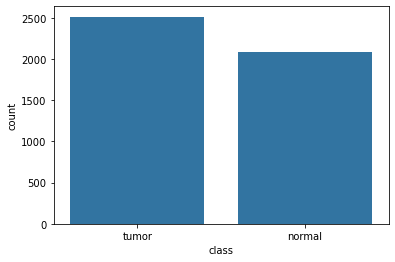

In [18]:
# The dataset seems not to much unbalanced

sns.countplot(data = metadata, x = 'class')
print(metadata['class'].value_counts())
print('\n')
print(metadata['class'].value_counts(normalize = True))

## Preprocessing the images

As we can see in the previous analysis, the images has different sizes, so we need to perform some transformations:

* Rescale the images
* Convert to gray color

In [19]:
tumor = []
healthy = []

for tumor_file in tumor_files:
    tumor.append(cv2.imread(tumor_file))
    
for healthy_file in healthy_files:
    healthy.append(cv2.imread(healthy_file))

In [20]:
len(tumor),len(healthy)

(2513, 2087)

Let's check the dimensions

In [21]:
height_tumor = [x.shape[0] for x in tumor]
width_tumor = [x.shape[1] for x in tumor]

height_healthy = [x.shape[0] for x in healthy]
width_healthy = [x.shape[1] for x in healthy]

height = height_tumor + height_healthy
width = width_tumor + width_healthy

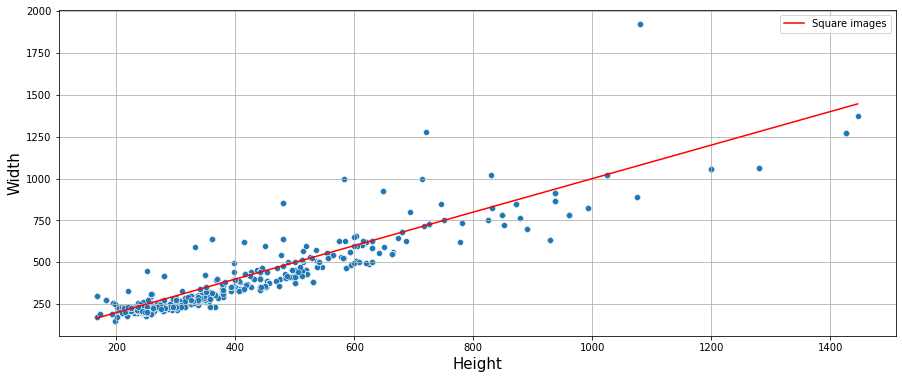

In [22]:
plt.figure(figsize = (15,6))
sns.scatterplot(x = height,y = width)
plt.plot([min(height),max(height)],[min(height),max(height)], color = 'red', label = 'Square images')
plt.xlabel('Height', fontsize = 15)
plt.ylabel('Width', fontsize = 15)
plt.legend()
plt.grid()
plt.show()

We can see that in general the images are rectangular.

Let's convert each image to gray scale (This is required because all the MRI images are in gray scale)

In [23]:
tumor_gray = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in tumor]
healthy_gray = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in healthy]

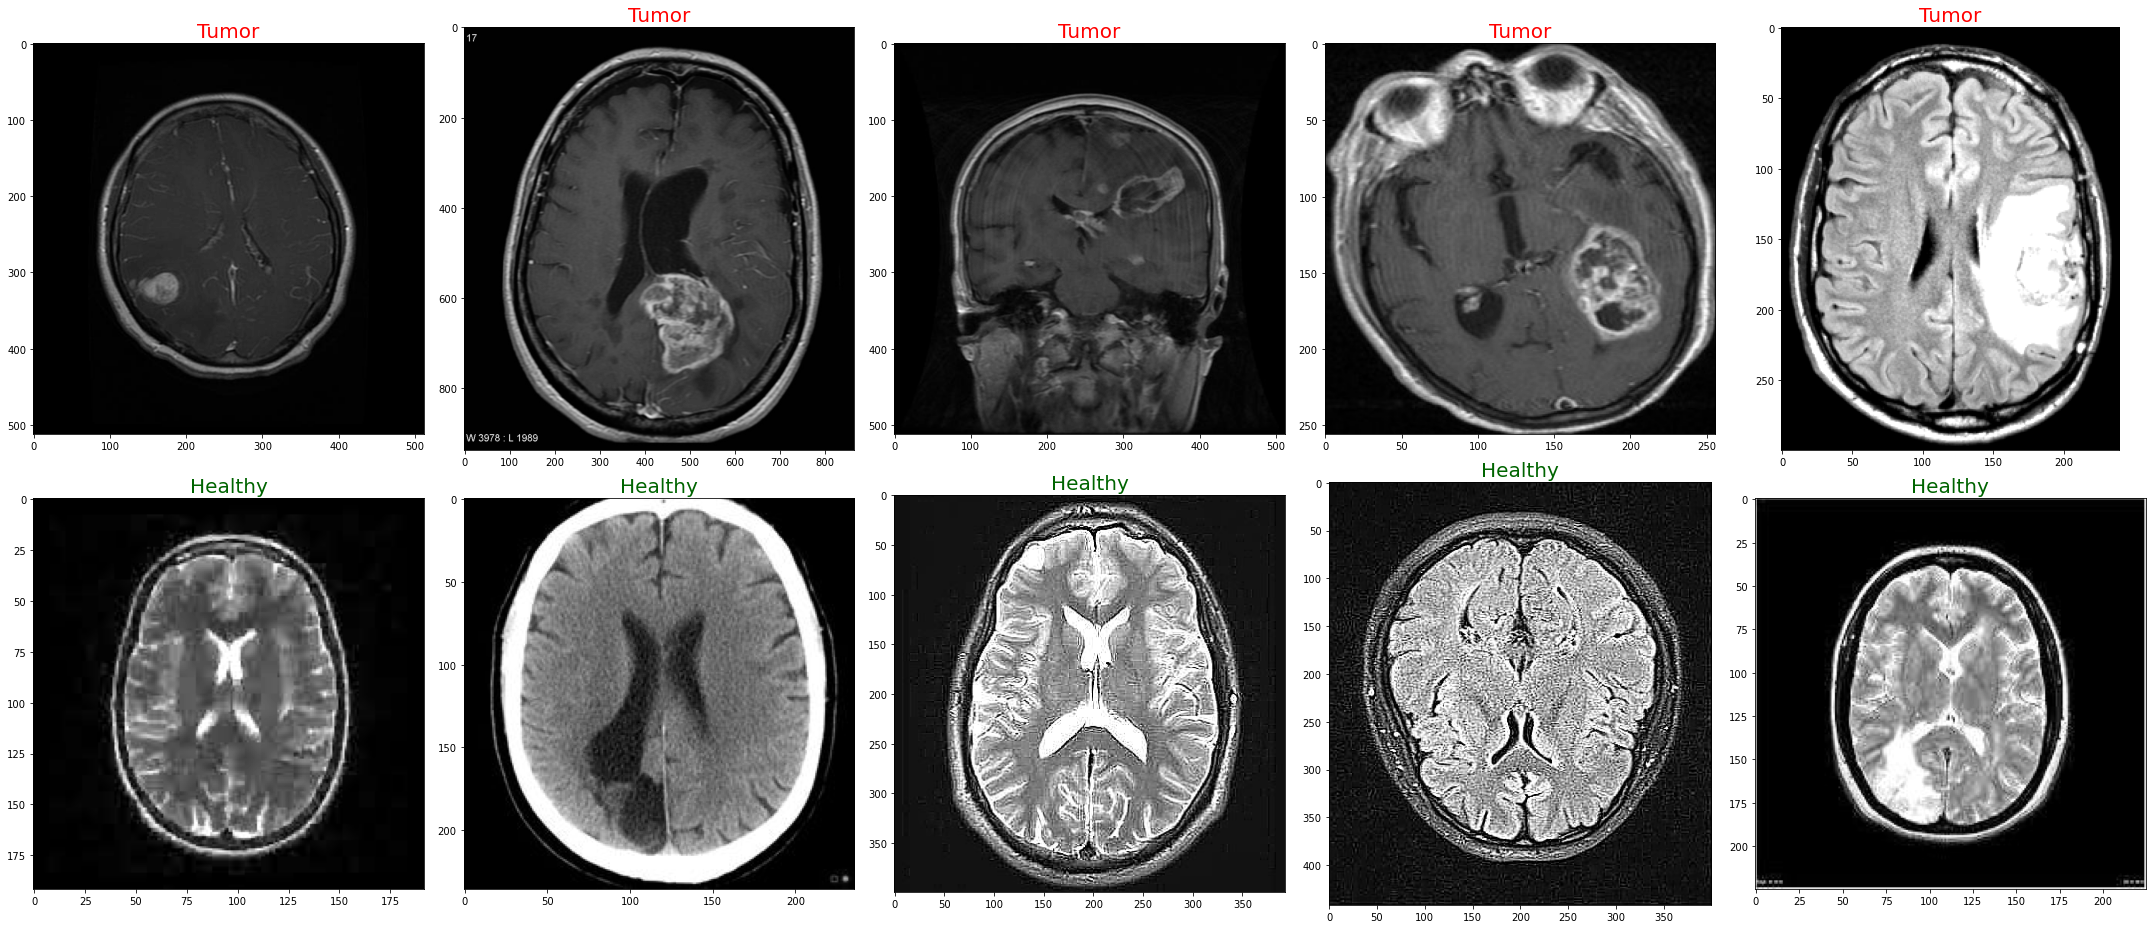

In [24]:
# Some graphs

fig, axs = plt.subplots(2,5, figsize = (30,13))
axs = axs.flatten()

idx_t = random.sample(range(len(tumor_gray)-1),5)
idx_h = random.sample(range(len(healthy_gray)-1),5)

for i in range(5):
    axs[i].imshow(tumor_gray[idx_t[i]], cmap = 'gray')
    axs[i+5].imshow(healthy_gray[idx_h[i]], cmap = 'gray')
    axs[i].set_title('Tumor', color = 'red', fontsize = 20)
    axs[i+5].set_title('Healthy', color = 'darkgreen', fontsize = 20)
fig.tight_layout()
plt.show()


In [25]:
# Rescale the images to 256x256
size = (256,256)
interpolation_method = cv2.INTER_LANCZOS4
tumor_gray_rescaled = [cv2.resize(image, size, interpolation_method) for image in tumor_gray]
healthy_gray_rescaled = [cv2.resize(image, size, interpolation_method) for image in healthy_gray]

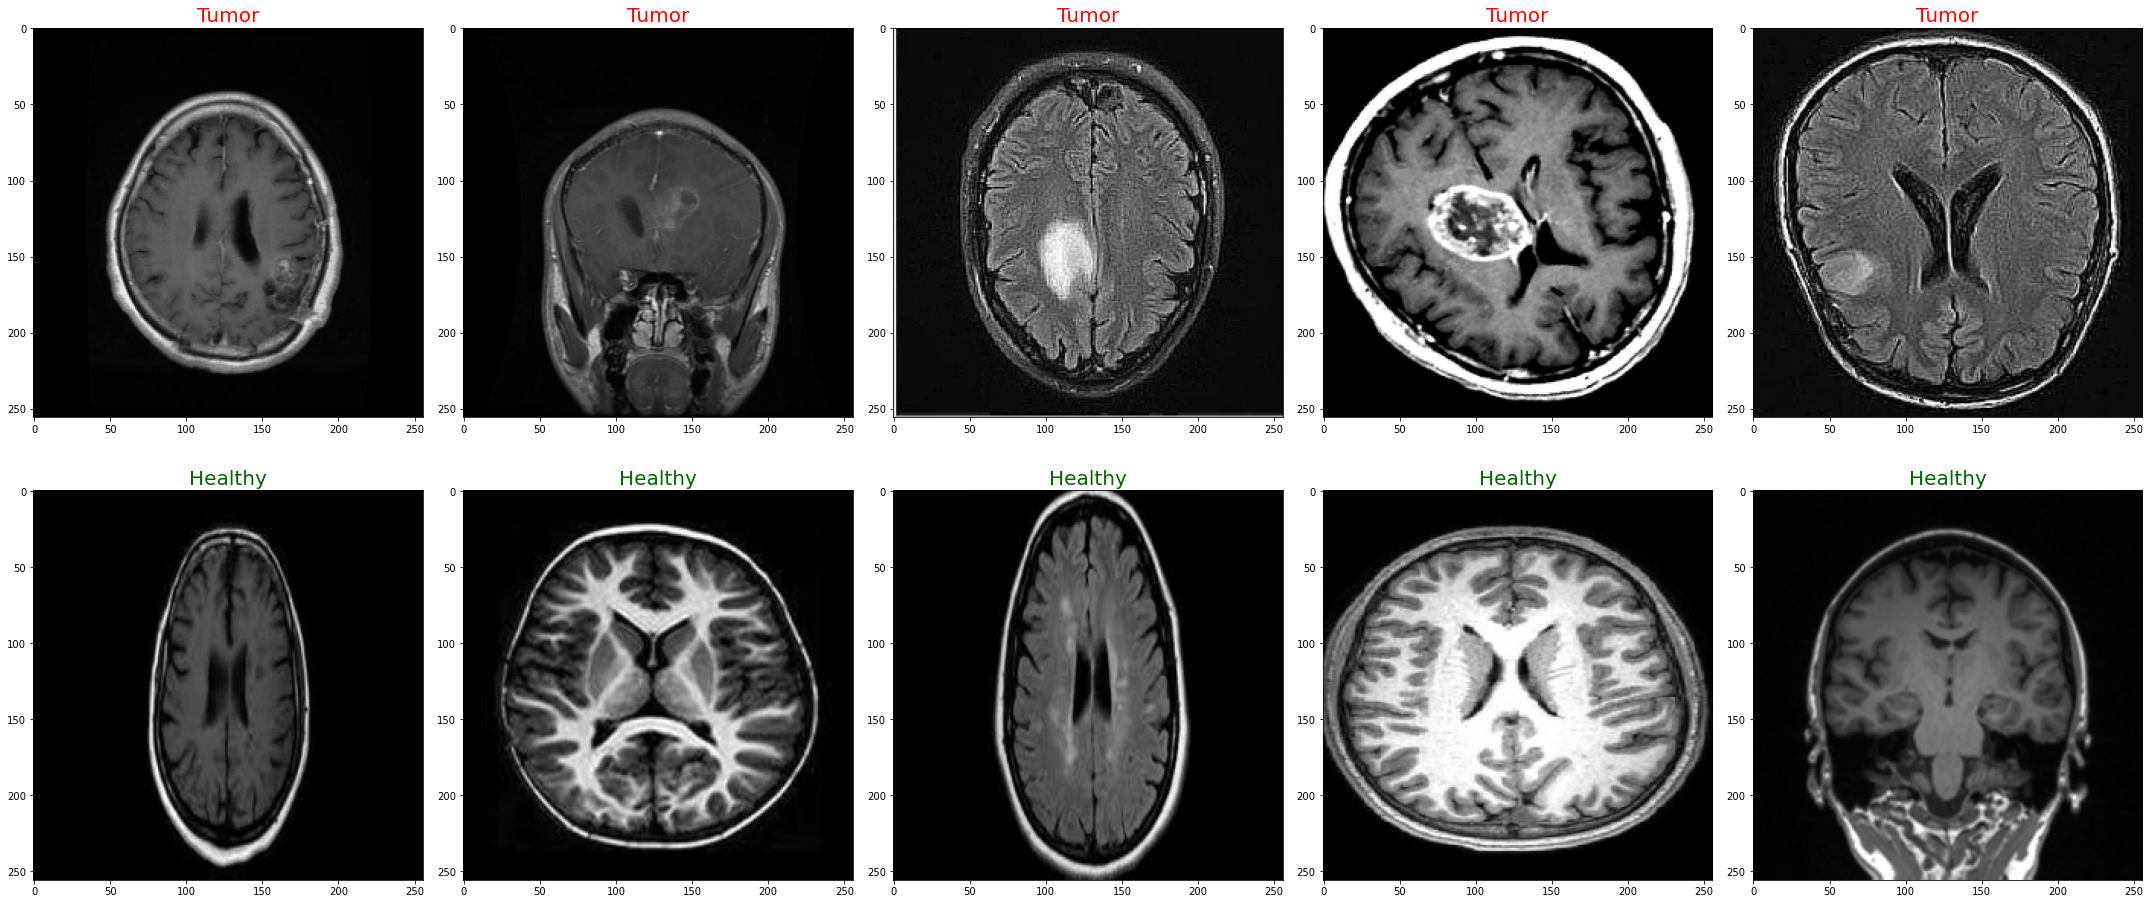

In [26]:
fig, axs = plt.subplots(2,5, figsize = (30,13))
axs = axs.flatten()

idx_t = random.sample(range(len(tumor_gray_rescaled)-1),5)
idx_h = random.sample(range(len(healthy_gray_rescaled)-1),5)

for i in range(5):
    axs[i].imshow(tumor_gray_rescaled[idx_t[i]], cmap = 'gray')
    axs[i+5].imshow(healthy_gray_rescaled[idx_h[i]], cmap = 'gray')
    axs[i].set_title('Tumor', color = 'red', fontsize = 20)
    axs[i+5].set_title('Healthy', color = 'darkgreen', fontsize = 20)
fig.tight_layout()
plt.show()

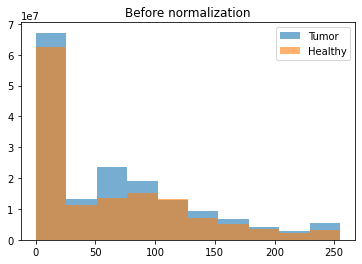

In [27]:
# Let's examine the values, i.e., the pixel value
# We will flatten each image and the concatenate all the images.
# Finally we will plot the histogram
plt.hist(np.concatenate([x.reshape(-1) for x in tumor_gray_rescaled]), alpha = 0.6, label = 'Tumor')
plt.hist(np.concatenate([x.reshape(-1) for x in healthy_gray_rescaled]), alpha = 0.6, label = 'Healthy')
plt.legend()
plt.title('Before normalization')
plt.show()

We can see that:

* there are many pixels with a value of 0, which represent the exterior of the image (the dark area)
* every pixel value is between (0,255).

Based on the last item, we can normalize the images to be in range (0,1)

In [28]:
tumor_gray_final = [image.astype(float)/255.0 for image in tumor_gray_rescaled]
healthy_gray_final = [image.astype(float)/255.0 for image in healthy_gray_rescaled]

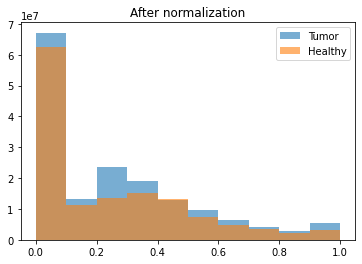

In [29]:
plt.hist(np.concatenate([x.reshape(-1) for x in tumor_gray_final]), alpha = 0.6, label = 'Tumor')
plt.hist(np.concatenate([x.reshape(-1) for x in healthy_gray_final]), alpha = 0.6, label = 'Healthy')
plt.legend()
plt.title('After normalization')
plt.show()

## Train/test split

We will split the dataset 80%-20% for train and test, respectively.

We will mantain the tumor/healthy ratio.

In [30]:
idx_train_tumor = random.sample(range(len(tumor_gray_final)),round(0.8*len(tumor_gray_final)))
idx_test_tumor = [x for x in range(len(tumor_gray_final)) if x not in idx_train_tumor]

idx_train_healthy = random.sample(range(len(healthy_gray_final)),round(0.8*len(healthy_gray_final)))
idx_test_healthy = [x for x in range(len(healthy_gray_final)) if x not in idx_train_healthy]

In [31]:
# Check the number of values
print(len(tumor_gray_final) == len(idx_train_tumor) + len(idx_test_tumor))
print(len(healthy_gray_final) == len(idx_train_healthy) + len(idx_test_healthy))
# Check if there is a leak (the set should be empty always)
print(set(idx_train_tumor).intersection(set(idx_test_tumor)))
print(set(idx_train_healthy).intersection(set(idx_test_healthy)))

True
True
set()
set()


In [32]:
X_train = [tumor_gray_final[idx] for idx in idx_train_tumor] + [healthy_gray_final[idx] for idx in idx_train_healthy]
X_test = [tumor_gray_final[idx] for idx in idx_test_tumor] + [healthy_gray_final[idx] for idx in idx_test_healthy]

# For the first models we need to ravel the images
X_train_ravel = [x.ravel() for x in X_train]
X_test_ravel = [x.ravel() for x in X_test]

# Tumor:= 1, Healthy:= 0
y_train = [1]*len(idx_train_tumor) + [0]*len(idx_train_healthy)
y_test = [1]*len(idx_test_tumor) + [0]*len(idx_test_healthy)

## Models

In [63]:
# Save the cross validation score per model
scores = {}

### Naive Bayes

In [456]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_ravel,y_train)

GaussianNB()

-------------------- Train --------------------
Accuracy: 0.5856
Precision: 0.7148
Recall: 0.4015
AUC: 0.6043
F1 score: 0.5142
-------------------- Test --------------------
Accuracy: 0.6
Precision: 0.7304
Recall: 0.4254
AUC: 0.618
F1 score: 0.5377


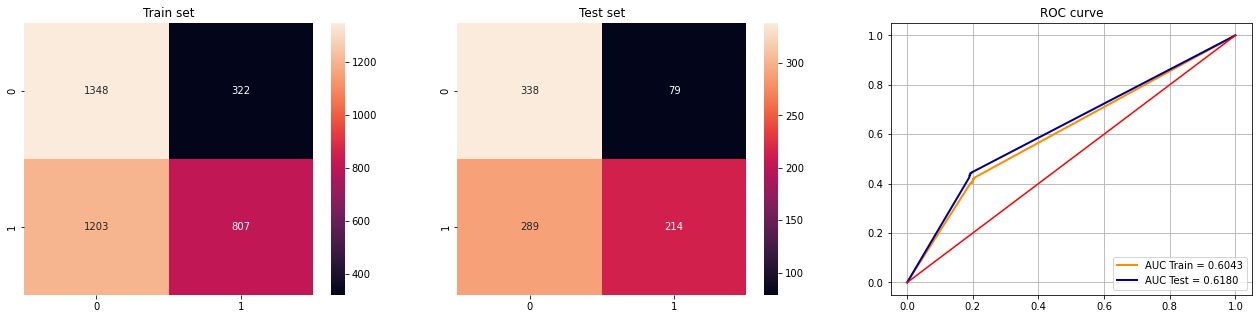

In [457]:
get_metrics(naive_bayes,X_train_ravel,X_test_ravel,y_train,y_test, roc = True)

In [58]:
cv_scores = cross_val_score(GaussianNB(), X_train_ravel,y_train, cv = 10, scoring = 'recall')
scores['Naive'] = cv_scores

### Random Forest Classifier

In [458]:
rf_1 = RandomForestClassifier()
rf_1.fit(X_train_ravel,y_train)

RandomForestClassifier()

-------------------- Train --------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC: 1.0
F1 score: 1.0
-------------------- Test --------------------
Accuracy: 0.975
Precision: 0.9743
Recall: 0.9801
AUC: 0.9745
F1 score: 0.9772


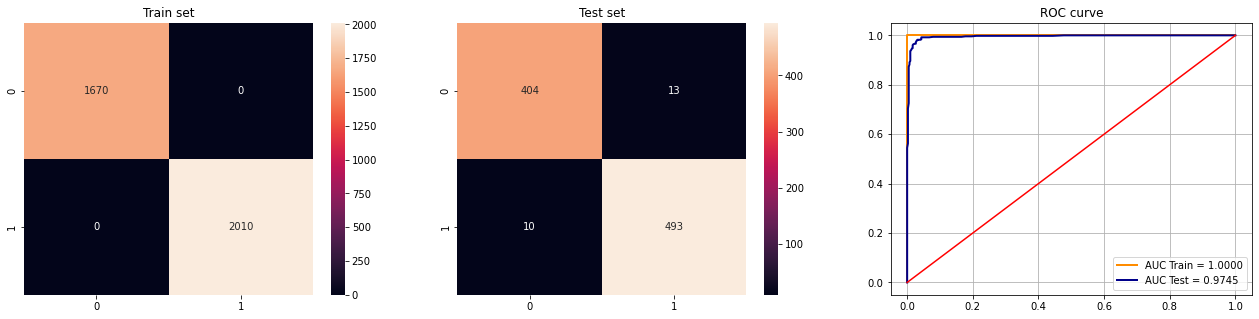

In [459]:
get_metrics(rf_1,X_train_ravel,X_test_ravel,y_train,y_test, roc = True)

In [462]:
with open('models/rf_1.pkl', 'wb') as file:
    pickle.dump(rf_1, file)

In [66]:
cv_scores = cross_val_score(RandomForestClassifier(), X_train_ravel,y_train, cv = 10, scoring = 'recall')
scores['RF'] = cv_scores

### Logistic Regression

In [463]:
logistic_1 = LogisticRegression()
logistic_1.fit(X_train_ravel,y_train)

LogisticRegression()

-------------------- Train --------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC: 1.0
F1 score: 1.0
-------------------- Test --------------------
Accuracy: 0.962
Precision: 0.9588
Recall: 0.9722
AUC: 0.9609
F1 score: 0.9654


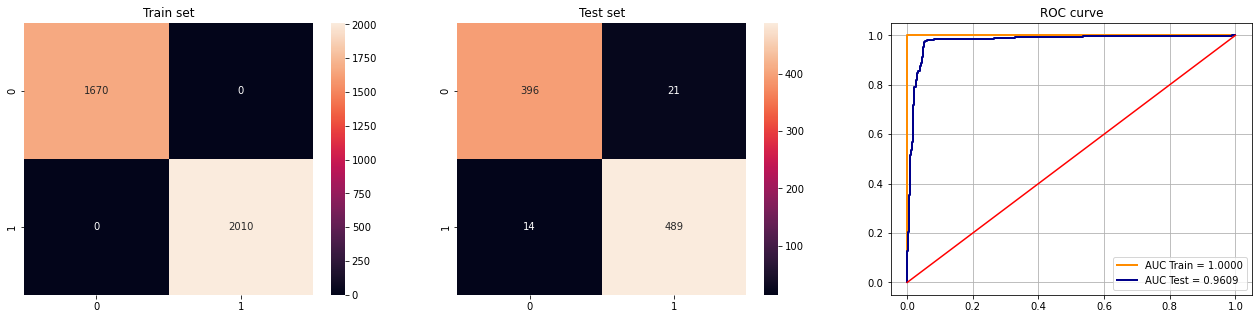

In [464]:
get_metrics(logistic_1,X_train_ravel,X_test_ravel,y_train,y_test, roc = True)

In [465]:
with open('models/logistic_1.pkl', 'wb') as file:
    pickle.dump(logistic_1, file)

In [67]:
cv_scores = cross_val_score(LogisticRegression(), X_train_ravel,y_train, cv = 10, scoring = 'recall')
scores['Logistic'] = cv_scores

### Decision Tree Clasifier

In [466]:
decision_tree_1 = DecisionTreeClassifier()
decision_tree_1.fit(X_train_ravel,y_train)

DecisionTreeClassifier()

-------------------- Train --------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC: 1.0
F1 score: 1.0
-------------------- Test --------------------
Accuracy: 0.887
Precision: 0.9148
Recall: 0.8748
AUC: 0.8882
F1 score: 0.8943


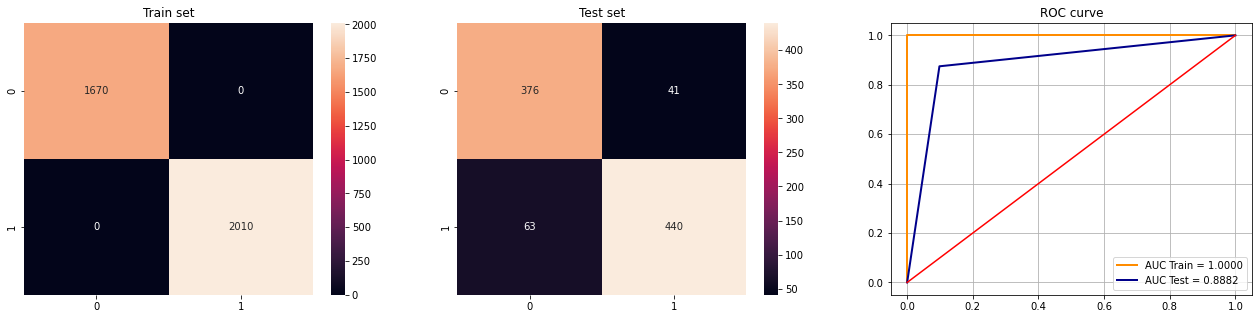

In [467]:
get_metrics(decision_tree_1,X_train_ravel,X_test_ravel,y_train,y_test, roc = True)

In [468]:
with open('models/decision_tree_1.pkl', 'wb') as file:
    pickle.dump(decision_tree_1, file)

In [68]:
cv_scores = cross_val_score(DecisionTreeClassifier(), X_train_ravel,y_train, cv = 10, scoring = 'recall')
scores['Decision_tree'] = cv_scores

### KNN

In [469]:
knn_1 = KNeighborsClassifier()
knn_1.fit(X_train_ravel,y_train)

KNeighborsClassifier()

-------------------- Train --------------------
Accuracy: 0.938
Precision: 0.967
Recall: 0.9179
AUC: 0.9401
F1 score: 0.9418
-------------------- Test --------------------
Accuracy: 0.8783
Precision: 0.9316
Recall: 0.839
AUC: 0.8823
F1 score: 0.8828


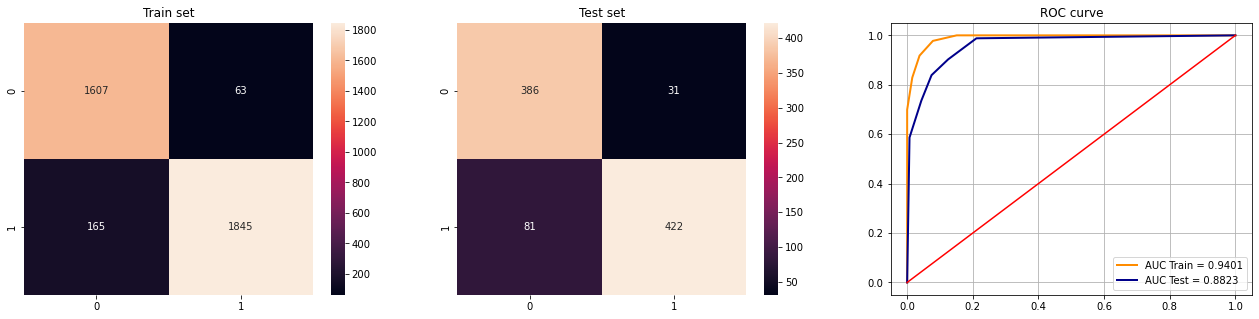

In [470]:
get_metrics(knn_1,X_train_ravel,X_test_ravel,y_train,y_test, roc = True)

In [471]:
with open('models/knn_1.pkl', 'wb') as file:
    pickle.dump(knn_1, file)

In [78]:
cv_scores = cross_val_score(KNeighborsClassifier(), X_train_ravel,y_train, cv = 10, scoring = 'recall')
scores['KNN'] = cv_scores

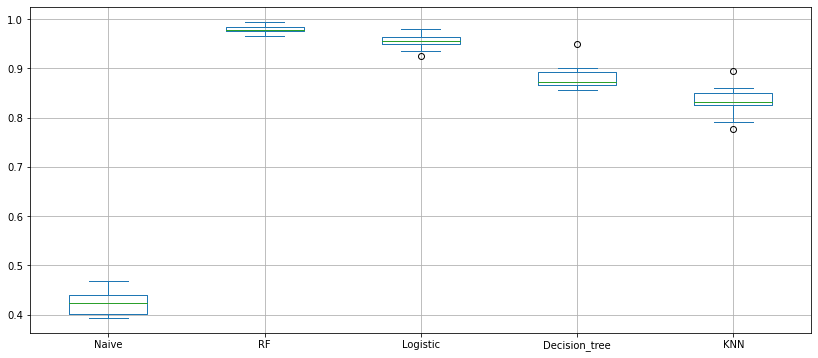

In [86]:
pd.DataFrame(scores).plot(kind = 'box', figsize = (14,6))
plt.grid()

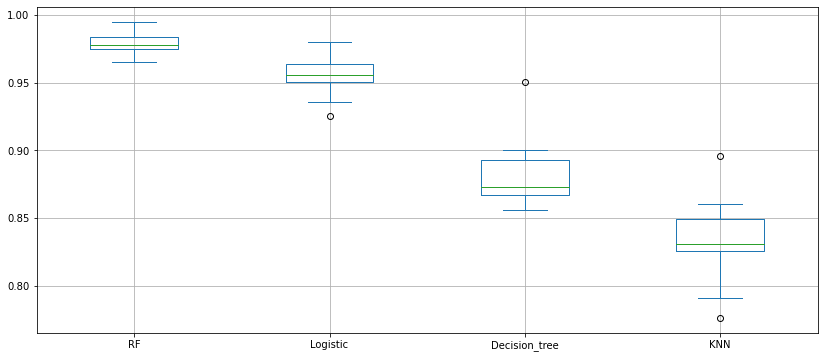

In [87]:
pd.DataFrame(scores).iloc[:,1:].plot(kind = 'box', figsize = (14,6))
plt.grid()

In [35]:
# pd.DataFrame(scores).to_csv('misc/models_cross_val.csv')

### Deep Learning models

1) From scratch

In [201]:
model = Sequential()

input_shape = (256,256,1)

model.add(InputLayer(input_shape = input_shape))
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))


In [202]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
batch_normalization_54 (Batc (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
batch_normalization_55 (Batc (None, 60, 60, 128)     

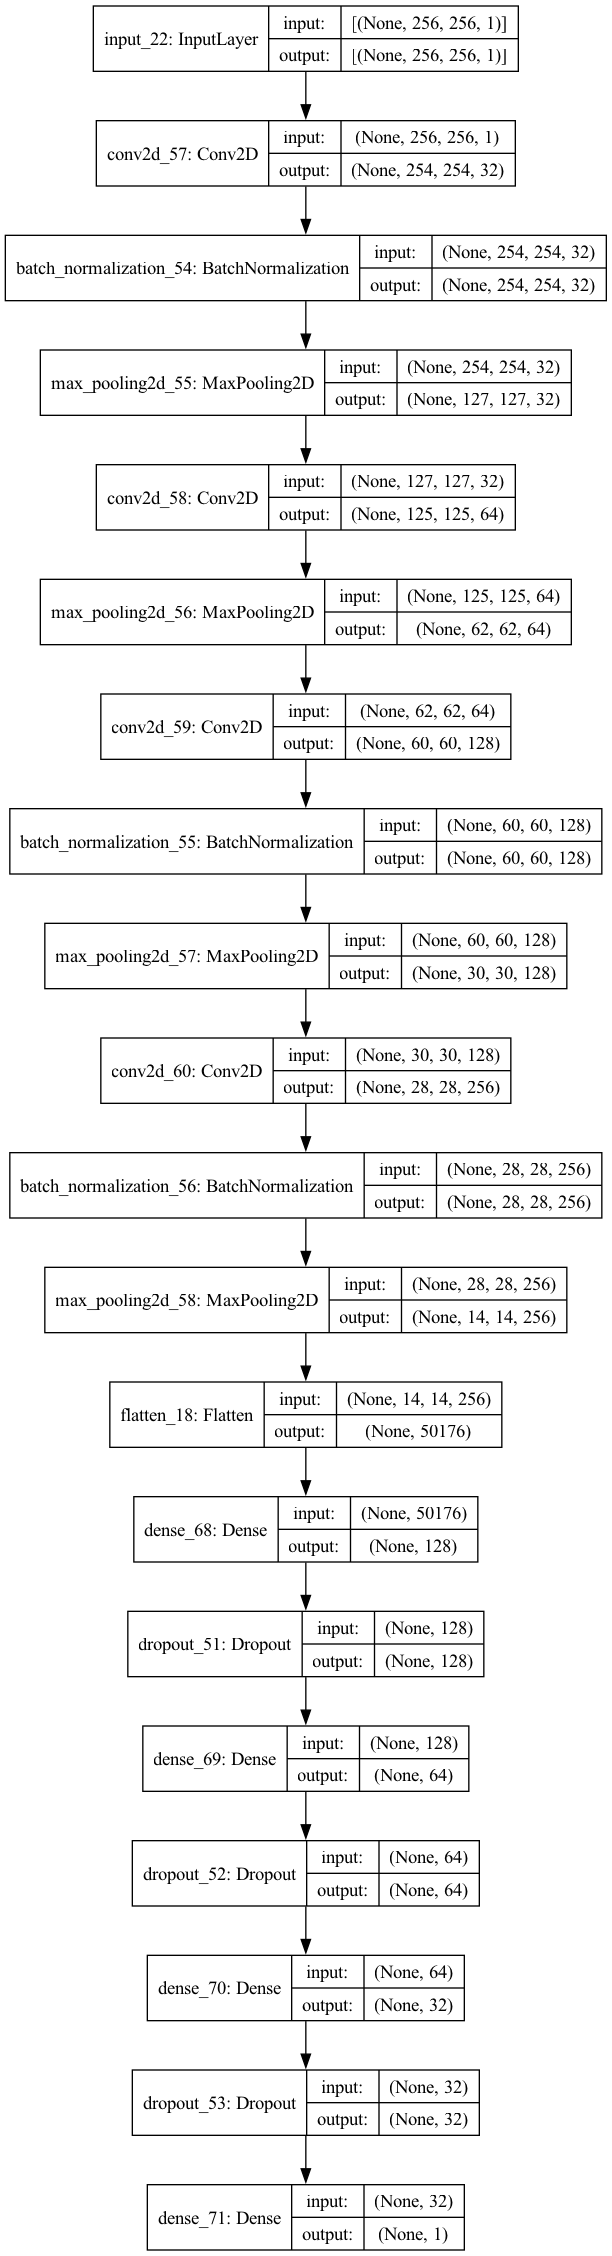

In [473]:
tf.keras.utils.plot_model(
    model, to_file='models/model_cnn_1.png', show_shapes=True,
    show_layer_names=True,
)

In [203]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



In [204]:
history = model.fit(np.expand_dims(np.array(X_train), axis = -1), np.array(y_train).astype(float), validation_split = 0.2, epochs = 100, verbose = 1, batch_size = 10)

Epoch 1/100


2024-02-11 04:30:43.787713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x1xi1>'
loc

294/295 [============================>.] - ETA: 0s - loss: 6.2985 - accuracy: 0.6240

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShad

295/295 [==============================] - ETA: 0s - loss: 6.2921 - accuracy: 0.6239

2024-02-11 04:31:04.337235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x1xi1>'


295/295 [==============================] - 23s 68ms/step - loss: 6.2858 - accuracy: 0.6239 - val_loss: 6.8926 - val_accuracy: 0.0000e+00
Epoch 2/100
  1/295 [..............................] - ETA: 28s - loss: 0.4972 - accuracy: 0.7000

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x1xi1>'


295/295 [==============================] - 17s 58ms/step - loss: 1.0034 - accuracy: 0.6609 - val_loss: 1.1017 - val_accuracy: 0.0231
Epoch 3/100
295/295 [==============================] - 20s 69ms/step - loss: 0.7868 - accuracy: 0.6691 - val_loss: 0.5944 - val_accuracy: 0.5666
Epoch 4/100
295/295 [==============================] - 17s 59ms/step - loss: 0.6770 - accuracy: 0.6778 - val_loss: 0.8808 - val_accuracy: 0.1807
Epoch 5/100
295/295 [==============================] - 908s 3s/step - loss: 0.5457 - accuracy: 0.7138 - val_loss: 0.7109 - val_accuracy: 0.1997
Epoch 6/100
295/295 [==============================] - 17s 56ms/step - loss: 0.5609 - accuracy: 0.7140 - val_loss: 0.8310 - val_accuracy: 0.1087
Epoch 7/100
295/295 [==============================] - 17s 56ms/step - loss: 0.6407 - accuracy: 0.7430 - val_loss: 0.8061 - val_accuracy: 0.1902
Epoch 8/100
295/295 [==============================] - 100s 339ms/step - loss: 0.6978 - accuracy: 0.7234 - val_loss: 1.6214 - val_accuracy: 0.0

In [214]:
# Save the model!
# tf.saved_model.save(model, 'models/cnn_1')
model.save('models/cnn_1')

INFO:tensorflow:Assets written to: models/cnn_1/assets


In [5]:
model.save('models/cnn_1.h5')

In [33]:
# load the model
model = tf.keras.models.load_model('models/cnn_1.h5')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-02-20 03:32:37.970433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-20 03:32:37.970670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [264]:
pd.DataFrame(history.history).to_csv('misc/cnn_1_history.csv')

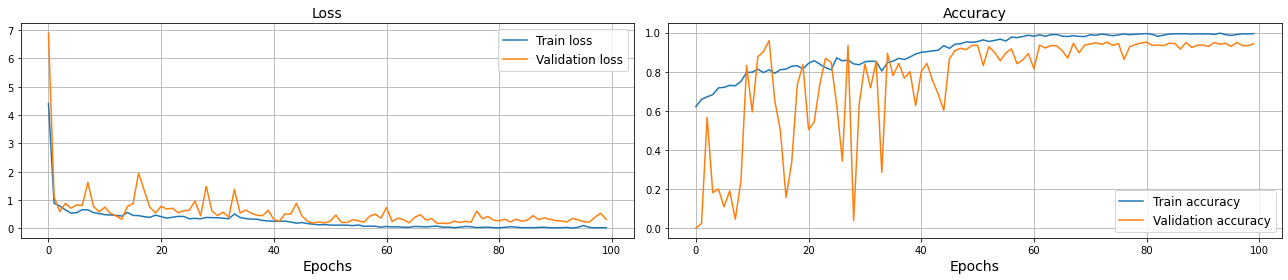

In [260]:
fig, axs = plt.subplots(1,2,figsize = (18,4))
axs = axs.flatten()

axs[0].plot(history.history['loss'], label = 'Train loss')
axs[0].plot(history.history['val_loss'], label = 'Validation loss')
axs[0].grid()
axs[0].set_xlabel('Epochs',fontsize = 14)
axs[0].set_title('Loss',fontsize = 14)
axs[0].legend(fontsize = 12)

axs[1].plot(history.history['accuracy'], label = 'Train accuracy')
axs[1].plot(history.history['val_accuracy'], label = 'Validation accuracy')
axs[1].grid()
axs[1].set_xlabel('Epochs',fontsize = 14)
axs[1].set_title('Accuracy',fontsize = 14)
axs[1].legend(fontsize = 12)
fig.tight_layout()
plt.show()

In [265]:
# What about the model performance on test set?
pred_test = model.predict(np.expand_dims(np.array(X_test), axis = -1))
pred_train = model.predict(np.expand_dims(np.array(X_train), axis = -1))

In [266]:
pred_train[:4]
# As we know, the result of a sigmoid layer is a number in [0,1].
# Let's plot an histogram

array([[1.        ],
       [0.99905473],
       [0.9999876 ],
       [0.9999999 ]], dtype=float32)

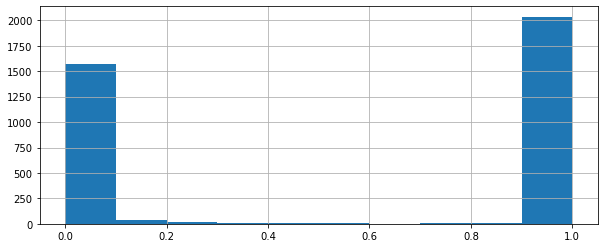

In [267]:
plt.figure(figsize = (10,4))
plt.hist(pred_train)
plt.grid()
plt.show()

* As we can see in the graph above, the majority of predicted values are very close to 0 and 1, but we have values in (0,1).
* We have to choose a $cutoff$ value such that:
$$ Pred(x) =
\begin{cases}
0 & \text{if } x < cutoff \newline
1 & \text{if } x \geq cutoff
\end{cases}.
$$

* We will choose a cutoff that maximize the F1 score.

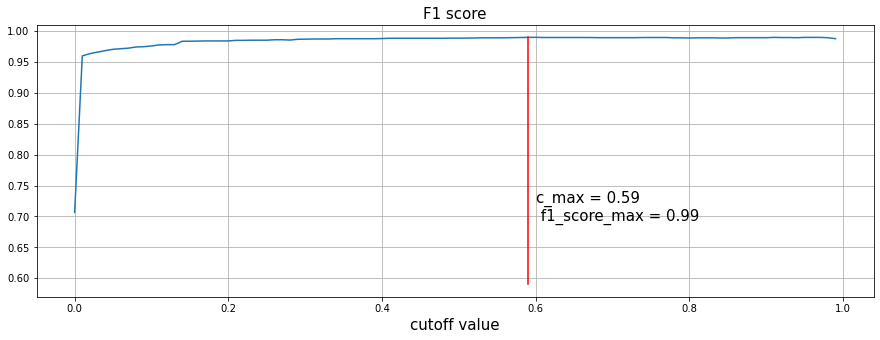

In [300]:
c = np.arange(0,1,0.01)
# calculamos el f1_score para cada punto de corte
f1_score_ = [f1_score(y_train,np.multiply(pred_train>c_,1)) for c_ in c]
# obtenemos el punto de corte que maximiza el f1_score
c_max = c[np.argmax(f1_score_)]

# hacemos un gráfico de c y los f1_score correspondientes
plt.figure(figsize = (15,5))
plt.plot(c,f1_score_)
# plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.plot([c_max,c_max],[c_max,np.max(f1_score_)], color = 'red')
plt.title("F1 score", fontsize = 15)
plt.text(c_max+0.01, np.max(f1_score_)*.7, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)), fontsize = 15)
plt.xlabel('cutoff value', fontsize = 15)
plt.grid()
plt.show()

* The optimat cutoff value is 0.59

* Now we can obtain the metrics for the Train and Test set

-------------------- Train --------------------
Accuracy: 0.9886
Precision: 0.9809
Recall: 0.9985
AUC: 0.9876
F1 score: 0.9896
-------------------- Test --------------------
Accuracy: 0.9696
Precision: 0.9524
Recall: 0.994
AUC: 0.967
F1 score: 0.9728


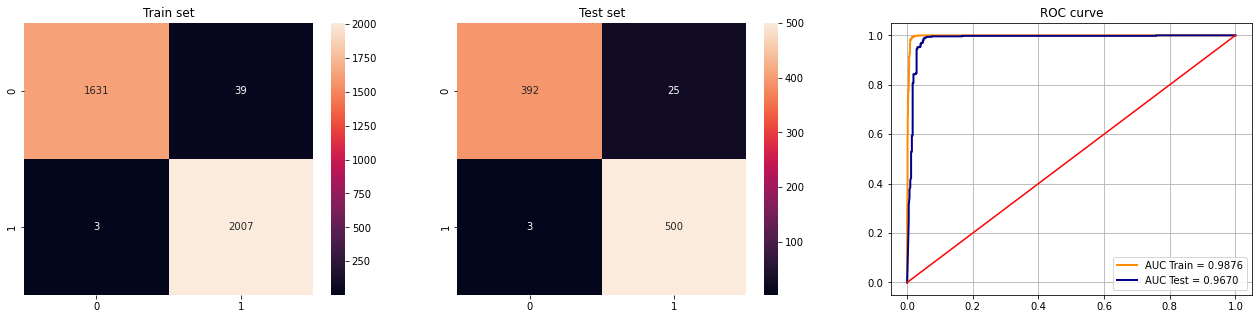

In [307]:
get_metrics(model,np.expand_dims(np.array(X_train), axis = -1),np.expand_dims(np.array(X_test), axis = -1),y_train,y_test, nn = True, cutoff = 0.59, roc = True)

## Summary

* In terms of metrics, the best model is the RandomForestClassifier.
* I consider the neural network model to be better because it exhibits a higher recall. In this context, it's important not only to correctly classify true positives (patients with tumors) but also to reduce false negatives (patients with tumors but classified as healthy).